In [1]:
import tensorflow as tf
from tensorflow import keras
import gym

In [2]:
env = gym.make('CartPole-v1')
obs = env.reset()
obs

array([ 0.01386777,  0.02936495, -0.02967557, -0.01236696])

In [3]:
env.render()

True

In [4]:
img = env.render(mode="rgb_array")
img.shape

(800, 1200, 3)

What actions are possible?

In [5]:
env.action_space

Discrete(2)

Accelerate right

In [6]:
action = 1
obs, reward, done, info = env.step(action)
obs

array([ 0.01445507,  0.22489964, -0.02992291, -0.3142632 ])

In [7]:
reward

1.0

In [8]:
done

False

In [9]:
info

{}

Hard coded policy 

In [10]:
def basic_policy(obs):
    return 0 if obs[1] < 0 else 1

totals = []

for episode in range(500):
    epi_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        epi_rewards += reward
        if done:
            break
            
    totals.append(epi_rewards)

In [11]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [12]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(9.406, 0.795716029749307, 8.0, 11.0)

Animate what it looks like

In [13]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(500):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)
    
    obs, reward, done, info = env.step(action)
    if done:
        break

In [14]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    anim = animation.FuncAnimation(fig, update_scene, 
                                   fargs=(frames, patch), 
                                   frames=len(frames), 
                                   repeat=repeat, 
                                   interval=interval)
    plt.close()
    return anim

In [15]:
plot_animation(frames)

In [16]:
n_inputs = 4

In [17]:
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid")
])

In [18]:
def render_policy_net(model, n_next_steps = 200, seed=42):
    frames = []
    env = gym.make('CartPole-v1')
    env.seed(seed)
    np.random.seed(seed)
    
    obs = env.reset()
    for step in range(n_next_steps):
        frames.append(env.render(mode="rgb_array"))
        
        left_prob = model.predict(obs.reshape(1,-1))
        action = int(np.random.rand() > left_prob)
        obs, reward, done, info = env.step(action)
        if done:
            break
            
    env.close()
    return frames

In [19]:
frames = render_policy_net(model)
plot_animation(frames)

We can make the same net play in 50 different environments in parallel (this will give us a diverse training batch at each step), and train for 5000 iterations. We also reset environments when they are done. We train the model using a custom training loop so we can easily use the predictions at each training step to advance the environments.

In [20]:

n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.124

In [21]:
frames = render_policy_net(model)
plot_animation(frames)

## Policy Gradient 

In [22]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads  

In [23]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    
    for epi in range(n_episodes):
        curr_rewards = []
        curr_grads = []
        
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grad = play_one_step(env, obs, model, loss_fn)
            curr_rewards.append(reward)
            curr_grads.append(grad)
            
            if done:
                break
                
        all_rewards.append(curr_rewards)
        all_grads.append(curr_grads)
        
    return all_rewards, all_grads

In [24]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for i in range(len(rewards) -2, -1, -1):
        discounted[i] += discounted[i + 1] * discount_factor
    
    return discounted

In [25]:
def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    
    return [(discounted_reward - reward_mean) / reward_std for discounted_reward in all_discounted_rewards]

In [26]:
discount_rewards([10, 0, -50], 0.8)

array([-22, -40, -50])

In [27]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], 0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [28]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [29]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [31]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid")
])

In [32]:
env = gym.make("CartPole-v1")
env.seed(42)

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    
    total_rewards = sum(map(sum, all_rewards))
    print("\rIteration: {}, mean rewards: {:.1f}".format(
        iteration, total_rewards / n_episodes_per_update), end="")
    
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    
    all_mean_grads = []
    
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
    
env.close()

Iteration: 149, mean rewards: 197.6

In [33]:
frames = render_policy_net(model)
plot_animation(frames)

## Deep Q-Network

In [93]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym .make('CartPole-v1')
input_shape = [4]
n_output = 2

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_output)
])

In [94]:
def epsilon_greedy_policy(state, epsilon = 0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    Q_values = model.predict(state[np.newaxis])
    return np.argmax(Q_values[0])

We will be storing agent's experience in a memory replay using a Deqeue

In [95]:
from collections import deque
replay_memory = deque(maxlen=2000)

In [96]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    
    states, actions, rewards, next_states, dones = [
        np.array([exp[field_index] for exp in batch])
        for field_index in range(5)
    ]
    
    return states, actions, rewards, next_states, dones

In [97]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [98]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_output)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [99]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

In [100]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step > best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 19, eps: 0.0108

In [101]:
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [102]:
rewards

[28,
 7,
 32,
 17,
 13,
 16,
 11,
 10,
 19,
 13,
 16,
 15,
 21,
 44,
 56,
 10,
 10,
 11,
 9,
 62,
 19,
 26,
 55,
 26,
 16,
 29,
 22,
 17,
 18,
 23,
 15,
 23,
 13,
 41,
 12,
 10,
 8,
 15,
 10,
 31,
 17,
 12,
 9,
 30,
 12,
 34,
 12,
 8,
 31,
 26,
 16,
 10,
 10,
 12,
 12,
 15,
 16,
 31,
 14,
 26,
 14,
 27,
 11,
 18,
 29,
 17,
 57,
 11,
 49,
 28,
 20,
 11,
 21,
 52,
 26,
 28,
 14,
 17,
 52,
 18,
 27,
 16,
 11,
 16,
 11,
 9,
 28,
 16,
 26,
 11,
 33,
 14,
 17,
 10,
 11,
 14,
 28,
 14,
 10,
 10,
 11,
 17,
 15,
 7,
 11,
 16,
 24,
 28,
 14,
 24,
 11,
 18,
 22,
 12,
 59,
 30,
 14,
 23,
 14,
 17,
 8,
 21,
 11,
 9,
 45,
 9,
 17,
 8,
 21,
 9,
 24,
 22,
 19,
 17,
 61,
 25,
 13,
 12,
 13,
 12,
 9,
 21,
 25,
 12,
 28,
 26,
 13,
 12,
 10,
 13,
 12,
 10,
 12,
 11,
 12,
 36,
 12,
 26,
 16,
 19,
 16,
 16,
 13,
 8,
 12,
 13,
 10,
 9,
 21,
 10,
 21,
 13,
 14,
 13,
 18,
 12,
 12,
 10,
 31,
 16,
 13,
 21,
 19,
 13,
 11,
 8,
 20,
 13,
 14,
 11,
 18,
 10,
 15,
 10,
 17,
 13,
 16,
 14,
 16,
 32,
 11,
 8,
 34,
 1

Saving figure dqn_rewards_plot


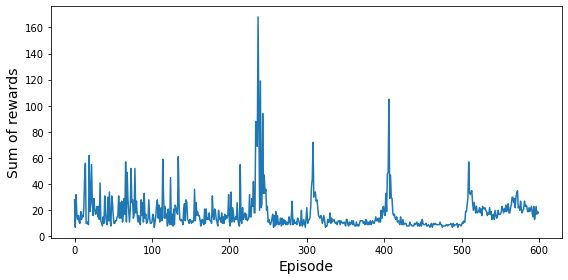

In [103]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [104]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done: 
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)